# **Feature engeneering**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pycountry_convert as pc
import os

os.chdir(os.path.dirname(os.getcwd()))      # Move to parent directory

from utils import compute_difficulty_index, compute_bmi



In [3]:
print(os.getcwd())

# Dataset download
cyclists_df = pd.read_csv('dataset/cyclists.csv')
races_df = pd.read_csv('dataset/races.csv')

/Users/francesco/Desktop/unipi/MAGISTRALE/2_ANNO/data_mining/dm-2425


#### ```categorical_height``` column


Since cycling is a sport in which, on average for the same height, the weight is similar, we group height by category with 5cm intervals to look for possible outliers in weight using conditional boxplots.

In [4]:
# Define the bins for the height category and create the feature
bins = [154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204]
labels = list(range(10))

cyclists_df['categorical_height'] = pd.cut(cyclists_df['height'], bins=bins, labels=labels, right=False, include_lowest=True)

print(cyclists_df[['height', 'categorical_height']].head(10))

   height categorical_height
0     NaN                NaN
1   182.0                  5
2   189.0                  7
3   192.0                  7
4   171.0                  3
5   177.0                  4
6     NaN                NaN
7   191.0                  7
8   192.0                  7
9     NaN                NaN


Conditional Box Plot

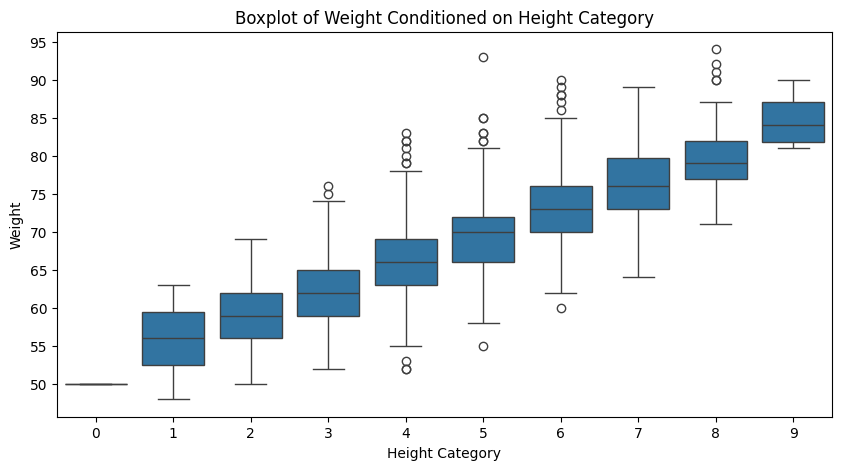

In [5]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='categorical_height', y='weight', data=cyclists_df)
plt.title('Boxplot of Weight Conditioned on Height Category')
plt.xlabel('Height Category')
plt.ylabel('Weight')

# Set y-axis intervals
plt.yticks(np.arange(50, cyclists_df['weight'].max() + 5, 5))

plt.show()

We show the number of cyclists in each defined category (excluding those with zero weight) to evaluate the significance of the outliers identified from the boxplots.

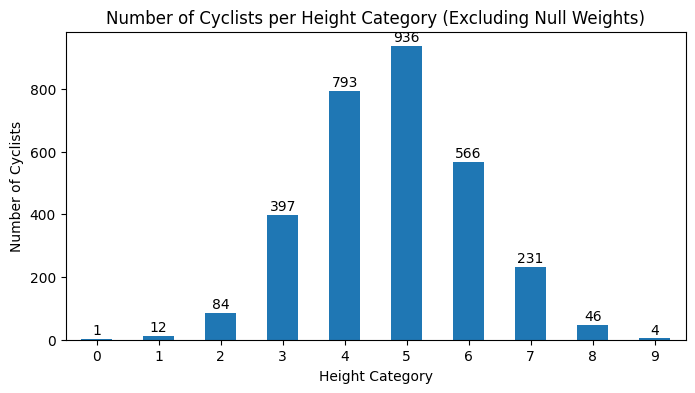

In [6]:
# Exclude cyclists with null weight
cyclists_df_non_null_weight = cyclists_df[cyclists_df['weight'].notnull()]

# Count the number of cyclists in each height category
categorical_height_counts = cyclists_df_non_null_weight['categorical_height'].value_counts().sort_index()

# Plot the results
plt.figure(figsize=(8, 4))
ax = categorical_height_counts.plot(kind='bar')
plt.title('Number of Cyclists per Height Category (Excluding Null Weights)')
plt.xlabel('Height Category')
plt.ylabel('Number of Cyclists')

# Add the count above each bin
for i, count in enumerate(categorical_height_counts):
    ax.text(i, count + 5, str(count), ha='center', va='bottom')

# Rotate x-axis labels to horizontal
plt.xticks(rotation=0)

plt.show()

#### ```BMI_idx``` column

In [7]:
cyclists_df['BMI_idx'] = cyclists_df.apply(
    lambda row: compute_bmi(row['weight'], row['height']),
    axis=1
)

print(cyclists_df[['weight', 'height', 'BMI_idx']].head(10))

   weight  height  BMI_idx
0     NaN     NaN      NaN
1    74.0   182.0    22.34
2    69.0   189.0    19.32
3    78.0   192.0    21.16
4    55.0   171.0    18.81
5    67.0   177.0    21.39
6     NaN     NaN      NaN
7    71.5   191.0    19.60
8    73.0   192.0    19.80
9     NaN     NaN      NaN


Categorizing BMI index

In [8]:
# Define the BMI categories and their corresponding labels
bmi_bins = [0, 18.5, 24.9, 29.9, np.inf]
bmi_labels = ['Underweight', 'Normal weight', 'Overweight', 'Obese']

# Create the 'BMI' categorical column
cyclists_df['BMI'] = pd.cut(cyclists_df['BMI_idx'], bins=bmi_bins, labels=bmi_labels, right=False, include_lowest=True)

# Display the first few rows to verify
print(cyclists_df[['_url', 'BMI_idx', 'BMI']].head(10))

                   _url  BMI_idx            BMI
0           bruno-surra      NaN            NaN
1            gerard-rue    22.34  Normal weight
2              jan-maas    19.32  Normal weight
3  nathan-van-hooydonck    21.16  Normal weight
4      jose-felix-parra    18.81  Normal weight
5       manuel-penalver    21.39  Normal weight
6          willy-moonen      NaN            NaN
7             chad-haga    19.60  Normal weight
8      joost-van-leijen    19.80  Normal weight
9          scott-davies      NaN            NaN


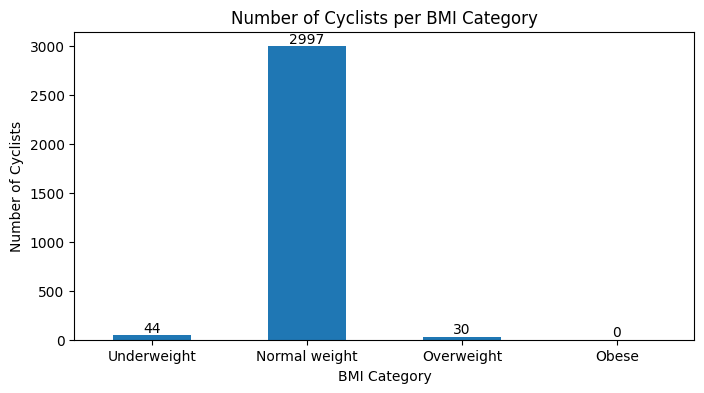

In [9]:
# Count the number of cyclists per BMI category
bmi_category_counts = cyclists_df['BMI'].value_counts().sort_index()

# Plot the results
plt.figure(figsize=(8, 4))
ax = bmi_category_counts.plot(kind='bar')
plt.title('Number of Cyclists per BMI Category')
plt.xlabel('BMI Category')
plt.ylabel('Number of Cyclists')

# Add the count above each bin
for i, count in enumerate(bmi_category_counts):
    ax.text(i, count + 5, str(count), ha='center', va='bottom')

# Rotate x-axis labels to horizontal
plt.xticks(rotation=0)

plt.show()

Null values for BMI index

In [10]:
null_bmi_idx_count = cyclists_df['BMI_idx'].isnull().sum()
print(f"Number of null values in BMI_idx column: {null_bmi_idx_count}")

Number of null values in BMI_idx column: 3063


As expected the most of the cyclists are normal weight

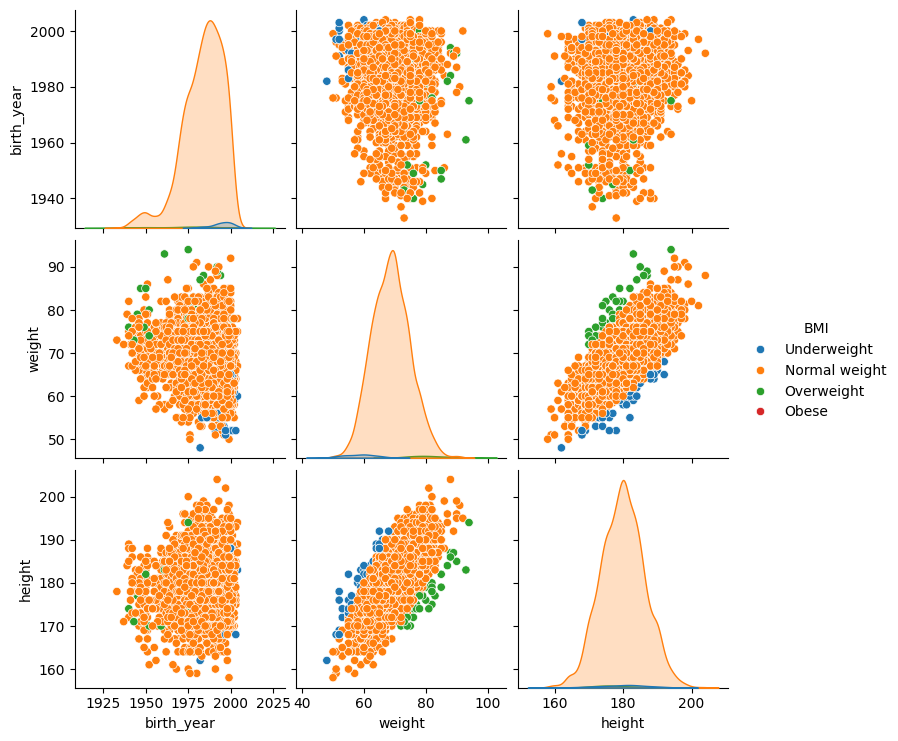

In [11]:
cyclists_df = cyclists_df.drop(columns=['BMI_idx'])
# Create a pairplot excluding the 'categorical_height' column
sns.pairplot(cyclists_df.drop(columns=[]), hue='BMI')
plt.show()

#### ```continent``` column

In [12]:
# Function to convert country name to continent
def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return 'Unknown'

# Apply the function to create a new column 'continent'
cyclists_df['continent'] = cyclists_df['nationality'].apply(country_to_continent)

# Display the first few rows to verify
print(cyclists_df[['nationality', 'continent']].head(10))

     nationality      continent
0          Italy         Europe
1         France         Europe
2    Netherlands         Europe
3        Belgium         Europe
4          Spain         Europe
5          Spain         Europe
6        Belgium         Europe
7  United States  North America
8    Netherlands         Europe
9            NaN        Unknown


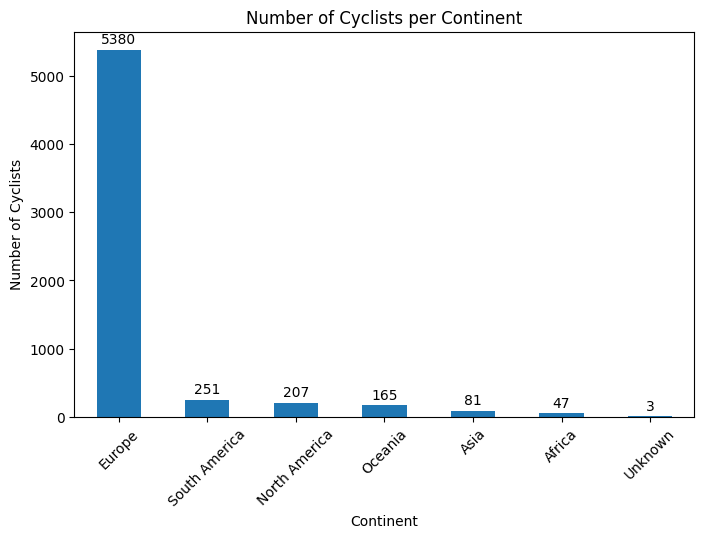

In [13]:
# Count the number of cyclists per continent
continent_counts = cyclists_df['continent'].value_counts()

# Plot the number of cyclists per continent as a histogram
plt.figure(figsize=(8, 5))
ax = continent_counts.plot(kind='bar')
plt.title('Number of Cyclists per Continent')
plt.xlabel('Continent')
plt.ylabel('Number of Cyclists')
plt.xticks(rotation=45)

# Add the count above each bin
for i, count in enumerate(continent_counts):
    ax.text(i, count + 50, str(count), ha='center', va='bottom')

plt.show()

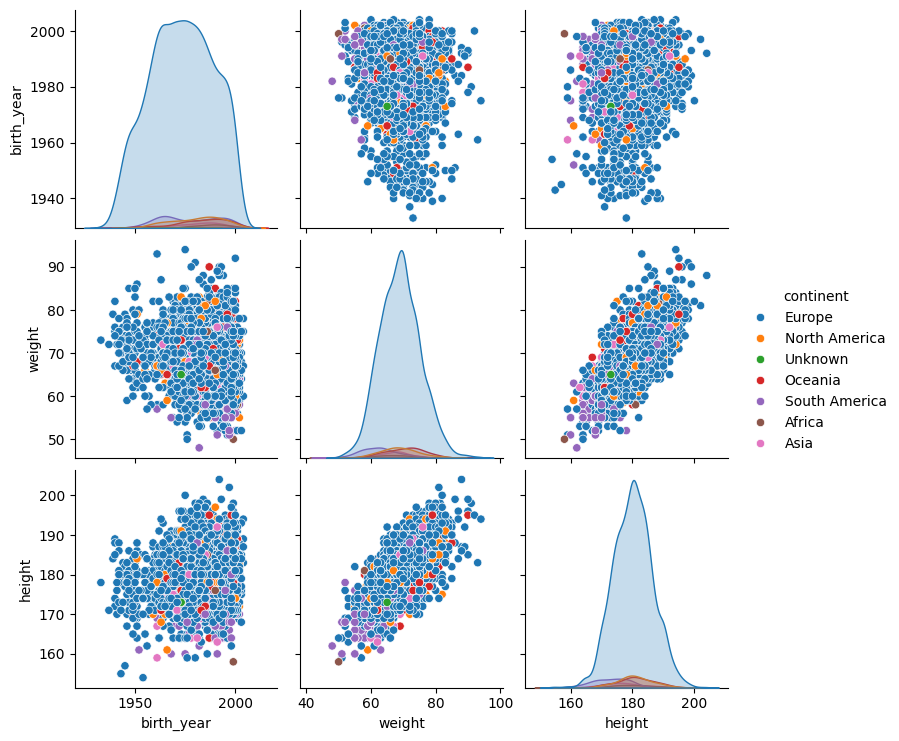

In [14]:
# Create a pairplot excluding the 'categorical_height' column
sns.pairplot(cyclists_df.drop(columns=['categorical_height']), hue='continent')
plt.show()

Given that majority of cyclists are european let's deep into european cyclist analysis

In [15]:
# Filter cyclists by European continent
european_df = cyclists_df[cyclists_df['continent'] == 'Europe'].drop(columns=['continent'])

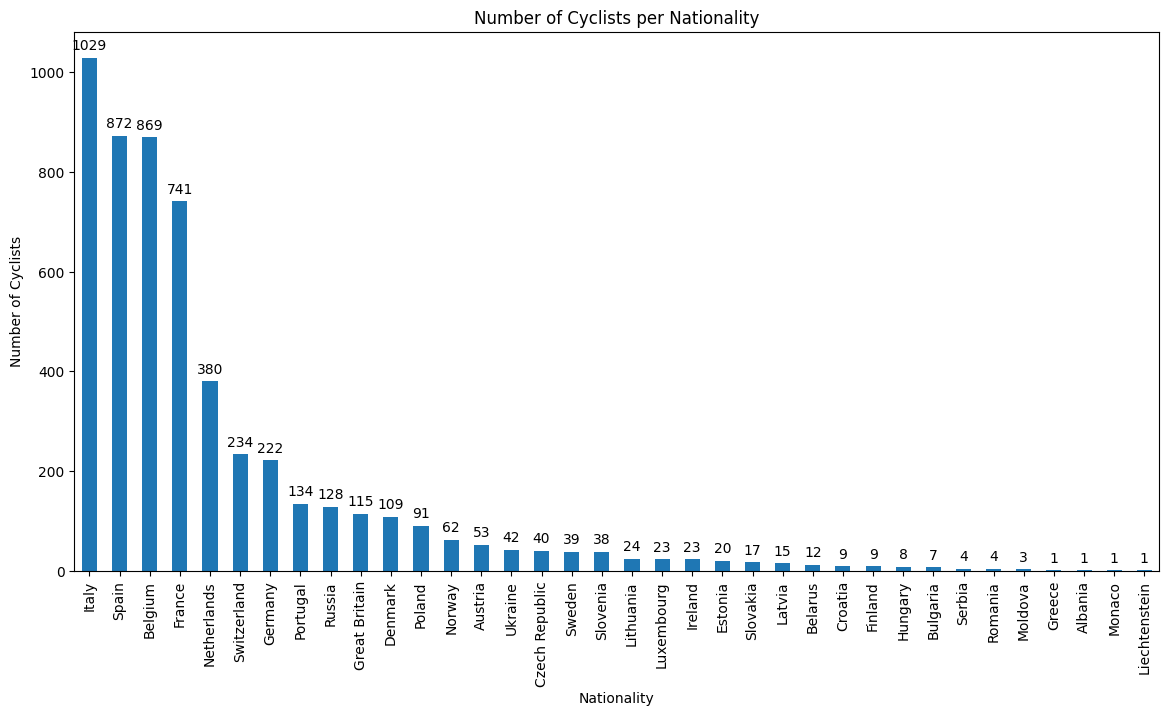

In [16]:
# Count the number of cyclists per nationality
nationality_counts = european_df['nationality'].value_counts()

# Plot the number of cyclists per nationality as a histogram
plt.figure(figsize=(14, 7))
ax = nationality_counts.plot(kind='bar')
plt.title('Number of Cyclists per Nationality')
plt.xlabel('Nationality')
plt.ylabel('Number of Cyclists')
plt.xticks(rotation=90)

# Add the count above each bin
for i, count in enumerate(nationality_counts):
    ax.text(i, count + 10, str(count), ha='center', va='bottom')

plt.show()

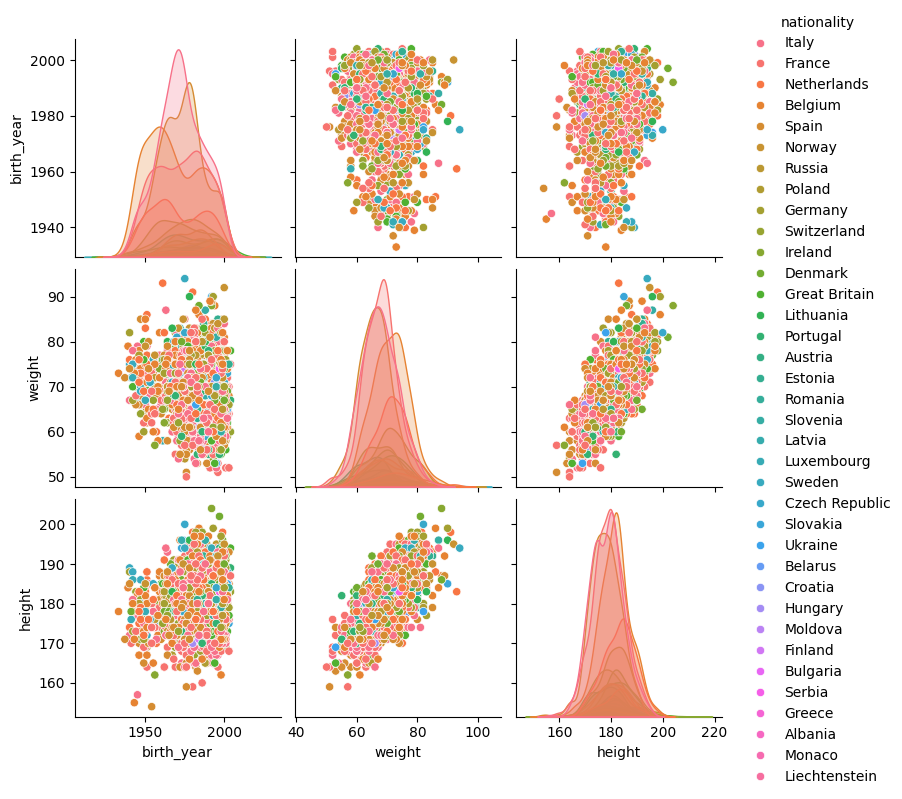

In [17]:
# Create a pairplot excluding the 'categorical_height' column
sns.pairplot(european_df.drop(columns=['categorical_height']), hue='nationality')
plt.show()

#### ```cyclist_win``` column

Count how many stages won each cyclist

In [18]:
# Group by cyclist and count the number of times position is 0
stages_won = races_df[races_df['position'] == 0].groupby('cyclist').size().reset_index(name='position')

# Add cyclists who never had position 0 with counter set to 0
all_cyclists = pd.DataFrame(races_df['cyclist'].unique(), columns=['cyclist'])
stages_won_df = pd.merge(all_cyclists, stages_won, on='cyclist', how='left').fillna(0)

# Ensure position is an integer
stages_won_df['position'] = stages_won_df['position'].astype(int)
# Merge the stages_won_df with cyclists_df to add the 'cyclist_win' column
cyclists_df = cyclists_df.merge(stages_won_df, left_on='_url', right_on='cyclist', how='left')

# Rename the 'position' column to 'cyclist_win'
cyclists_df = cyclists_df.rename(columns={'position': 'cyclist_win'})

# Drop the redundant 'cyclist' column
cyclists_df = cyclists_df.drop(columns=['cyclist'])

print(cyclists_df[["_url", "cyclist_win"]].head(3))

#check correctness of the computation (sum(races won) = num. of races)
print("Total cyclist_wins:", cyclists_df['cyclist_win'].sum())


          _url  cyclist_win
0  bruno-surra          0.0
1   gerard-rue          3.0
2     jan-maas          0.0
Total cyclist_wins: 5281.0


Some useful analysis on win column like max, min, counting...

In [19]:
cyclists_df['cyclist_win'].describe()

count    6095.000000
mean        0.866448
std         3.633101
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        92.000000
Name: cyclist_win, dtype: float64

Plot distribution of stages won

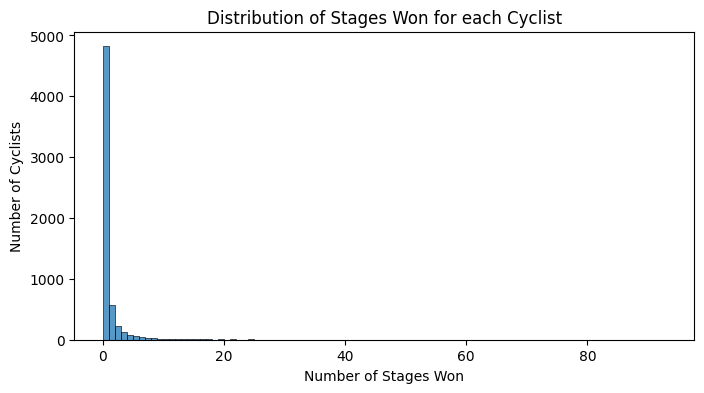

In [20]:
# Plot the distribution of stages won
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['cyclist_win'], bins=range(0, int(cyclists_df['cyclist_win'].max()) + 2), kde=False)
plt.title('Distribution of Stages Won for each Cyclist')
plt.xlabel('Number of Stages Won')
plt.ylabel('Number of Cyclists')
plt.show()

Scatter plot

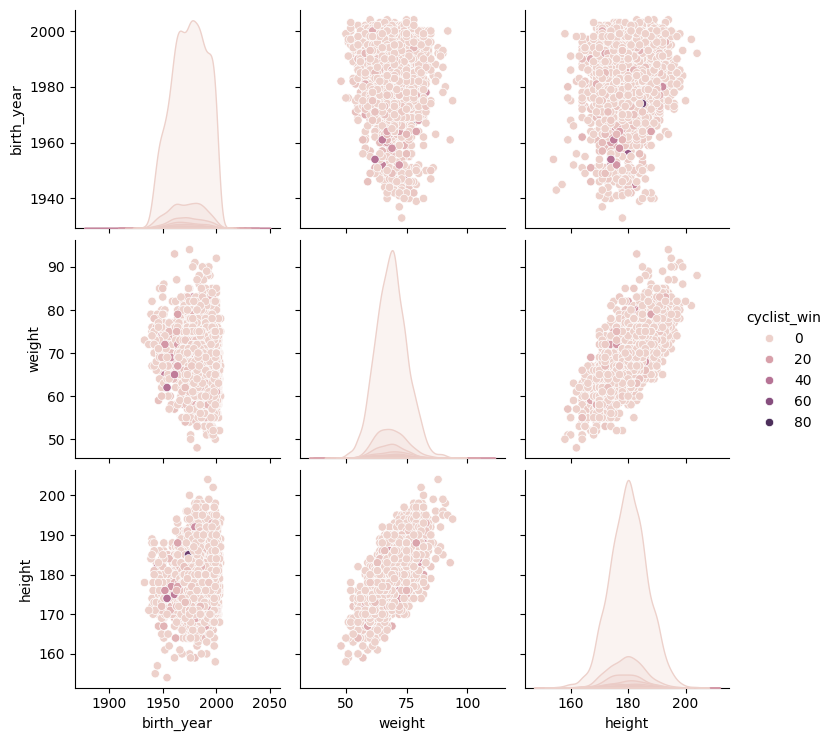

In [21]:
# Create a pairplot with 'cyclist_win' as the hue
sns.pairplot(cyclists_df.drop(columns=['categorical_height']), hue='cyclist_win')
plt.show()

#### ```team_win``` column

In [22]:
# Group by team and count the number of times position is 0
stages_won_by_team = races_df[races_df['position'] == 0].groupby('cyclist_team').size().reset_index(name='position')

# Add teams who never had position 0 with counter set to 0
all_teams = pd.DataFrame(races_df['cyclist_team'].unique(), columns=['cyclist_team'])
stages_won_team_df = pd.merge(all_teams, stages_won_by_team, on='cyclist_team', how='left').fillna(0)

# Ensure position is an integer
stages_won_team_df['position'] = stages_won_team_df['position'].astype(int)

# Rename the 'position' column to 'team_win'
stages_won_team_df = stages_won_team_df.rename(columns={'position': 'team_win'})

# Merge the stages_won_team_df with races_df to add the 'team_win' column
races_df = races_df.merge(stages_won_team_df, on='cyclist_team', how='left')

print(races_df[['cyclist_team', 'team_win']].head(10))


                           cyclist_team  team_win
0  vini-ricordi-pinarello-sidermec-1986      70.0
1                           norway-1987      88.0
2                                   NaN       NaN
3              navigare-blue-storm-1993      56.0
4                            spain-1991      48.0
5               kelme-costa-blanca-2000      69.0
6              navigare-blue-storm-1993      56.0
7                                   NaN       NaN
8                                   NaN       NaN
9                                   NaN       NaN


In [23]:
print(f"Null values in team_win column: {int(races_df['team_win'].isnull().sum())}")

Null values in team_win column: 159161


In [24]:
races_df['team_win'].describe()

count    430704.000000
mean         58.608676
std          23.144978
min           0.000000
25%          41.000000
50%          56.000000
75%          74.000000
max         134.000000
Name: team_win, dtype: float64

Distribution Plot

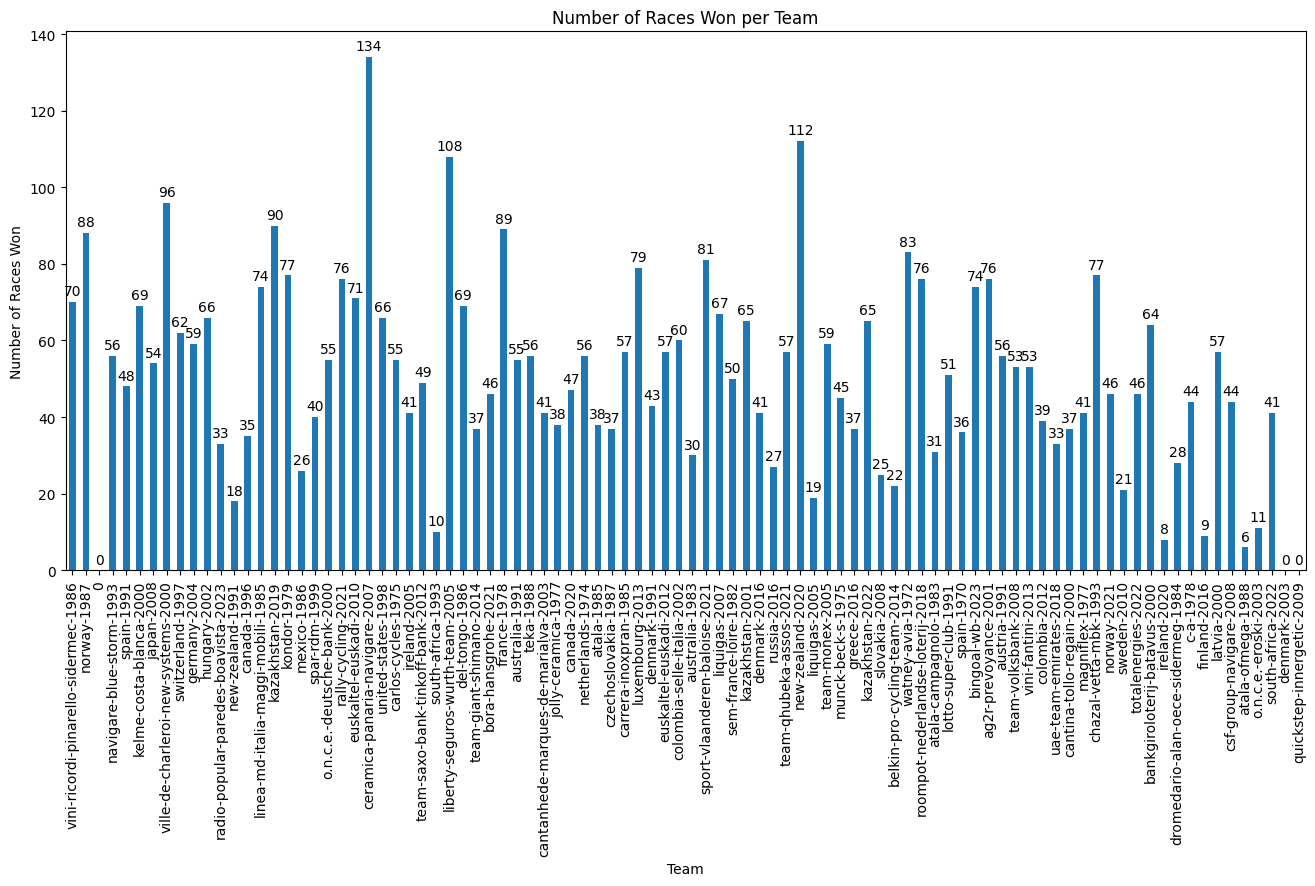

In [25]:
# Plot the number of races won per team as a histogram
plt.figure(figsize=(16, 7))
ax = stages_won_team_df.set_index('cyclist_team')['team_win'].plot(kind='bar')
plt.title('Number of Races Won per Team')
plt.xlabel('Team')
plt.ylabel('Number of Races Won')
plt.xticks(rotation=90)

# Add the count above each bin
for i, count in enumerate(stages_won_team_df['team_win']):
    ax.text(i, count + 1, str(count), ha='center', va='bottom')

plt.show()

#### ```difficulty_idx``` column

In [26]:
races_df['difficulty_idx'] = races_df.apply(
        lambda row: compute_difficulty_index(row['length']/1000, row['climb_total']/1000, row['profile']),
        axis=1
        )

In [27]:
print(f"Null values in avg_slope column: {int(races_df['difficulty_idx'].isnull().sum())}")

Null values in avg_slope column: 180773


In [28]:
races_df["difficulty_idx"].describe()

count    409092.000000
mean         51.617061
std          18.647909
min           0.430000
25%          47.610000
50%          55.400000
75%          62.320000
max         102.710000
Name: difficulty_idx, dtype: float64

Normalize this difficulty index

In [29]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the 'difficulty_index' column
races_df['difficulty_index_normalized'] = scaler.fit_transform(races_df[['difficulty_idx']]).round(2)
races_df.drop(columns=['difficulty_idx'], inplace=True)
races_df.rename(columns={'difficulty_index_normalized': 'difficulty_idx'}, inplace=True)

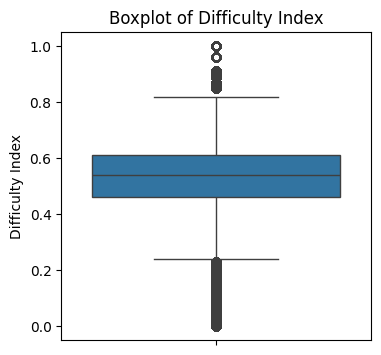

In [30]:
plt.figure(figsize=(4, 4))
sns.boxplot(y='difficulty_idx', data=races_df)
plt.title('Boxplot of Difficulty Index')
plt.ylabel('Difficulty Index')
plt.show()

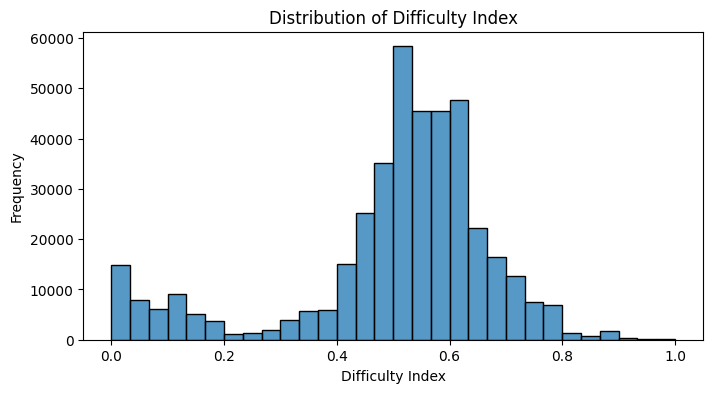

In [31]:
# Plot the distribution of the difficulty index
plt.figure(figsize=(8, 4))
sns.histplot(races_df['difficulty_idx'], bins=30)
plt.title('Distribution of Difficulty Index')
plt.xlabel('Difficulty Index')
plt.ylabel('Frequency')
plt.show()

##### ```min_duration``` column 

We decided to drop the ```delta``` column and the ```duration``` column as they contain many errors and as in the final clustering we will try to cluster stages and riders rather than riders and stages together. For this reason, we create a new feature min_duration that contains the total time taken for the first cyclist to finish the stage, as this could be another measure to assess the difficulty of the stage.

In [32]:
# DROP THIS CODE WHEN THE PROJECT IS FINISHED: this split is already done in DU

# Split the 'date' column into 'start_date' and 'duration'
races_df['date'] = pd.to_datetime(races_df['date'])
races_df['start_date'] = races_df['date'].dt.date
races_df['duration'] = races_df['date'].dt.time

In [33]:
# Group by '_url' and take the first entry in 'duration' for each group
races_df['min_duration'] = races_df.groupby('_url')['duration'].transform('first')

# Display the first few rows to verify
print(races_df[['duration', 'min_duration']].head(7))

# Convert 'min_duration' to total seconds
races_df['min_duration'] = races_df['min_duration'].apply(lambda x: int(pd.to_timedelta(str(x)).total_seconds()))

# Display the first few rows to verify
print(races_df[['min_duration']].head(7))

   duration min_duration
0  04:02:24     04:02:24
1  04:02:24     04:02:24
2  04:02:24     04:02:24
3  04:02:24     04:02:24
4  04:02:24     04:02:24
5  04:02:51     04:02:24
6  04:02:51     04:02:24
   min_duration
0         14544
1         14544
2         14544
3         14544
4         14544
5         14544
6         14544


In [34]:
races_df['min_duration'].describe()

count    589865.000000
mean      15145.920492
std        6128.634104
min          74.000000
25%       13389.000000
50%       16054.000000
75%       18660.000000
max       35886.000000
Name: min_duration, dtype: float64

In [35]:
grouped_df = races_df.groupby('min_duration')[['length', '_url']].value_counts().sort_index()
print(grouped_df)

min_duration  length    _url                          
74            1000.0    tour-de-france/1988/prologue       22
80            1150.0    giro-d-italia/2005/prologue       194
104           217000.0  tour-de-suisse/1988/stage-3        10
127           1900.0    tour-de-romandie/2008/prologue    150
145           212300.0  tour-de-suisse/1993/stage-4         6
                                                         ... 
30331         269000.0  tour-de-france/1985/stage-12      158
30910         155600.0  volta-a-catalunya/1999/stage-3    117
34088         320500.0  tour-de-france/1984/stage-21      124
34811         338000.0  tour-de-france/1984/stage-9       163
35886         8100.0    tour-de-romandie/1997/prologue     40
Name: count, Length: 5281, dtype: int64


### ```season``` column 

In [36]:
# Split the 'date' column into 'start_date' and 'duration'
races_df['start_date'] = pd.to_datetime(races_df['date']).dt.date

In [37]:

def get_season(date):
    month = date.month
    day = date.day

    if (month == 12 and day >= 21) or (month <= 2) or (month == 3 and day < 20):
        return 'Winter'
    elif (month == 3 and day >= 20) or (month <= 5) or (month == 6 and day < 21):
        return 'Spring'
    elif (month == 6 and day >= 21) or (month <= 8) or (month == 9 and day < 22):
        return 'Summer'
    else:
        return 'Autumn'

# Apply the custom get_season function to create a new column 'season'
races_df['season'] = races_df['start_date'].apply(lambda x: get_season(pd.to_datetime(x)))

# Display the first few rows to verify
print(races_df[['start_date', 'season']].head(5))

   start_date  season
0  1978-07-05  Summer
1  1978-07-05  Summer
2  1978-07-05  Summer
3  1978-07-05  Summer
4  1978-07-05  Summer


### ```cyclist_level``` column 

In [38]:
import bisect

# Group by '_url' and take only the first 4 rows of each group
races_df_top4 = races_df.groupby('_url').head(4)

# Initialize the dictionary
cyclist_performance = {}

# Iterate over each row in the grouped dataframe
for _, row in races_df_top4.iterrows():
    cyclist = row['cyclist']
    position = row['position']
    date = pd.to_datetime(row['start_date']).date()
    points = row['points']
    
    # Initialize the nested dictionary if the cyclist is not already in the dictionary
    if cyclist not in cyclist_performance:
        cyclist_performance[cyclist] = {
            'win_dates': [],
            'second_place_dates': [],
            'third_place_dates': [],
            'fourth_place_dates': [],
            'total_points': 0,
            'total_races': 0
        }
    
    # Add the date to the appropriate list based on the position
    if position == 0:
        bisect.insort(cyclist_performance[cyclist]['win_dates'], date)
    elif position == 1:
        bisect.insort(cyclist_performance[cyclist]['second_place_dates'], date)
    elif position == 2:
        bisect.insort(cyclist_performance[cyclist]['third_place_dates'], date)
    elif position == 3:
        bisect.insort(cyclist_performance[cyclist]['fourth_place_dates'], date)
    
    # Add the points to the total points if the position is 0, 1, 2, or 3
    if position in [0, 1, 2, 3]:
        cyclist_performance[cyclist]['total_points'] += points

# Count the total number of races for each cyclist
total_races = races_df['cyclist'].value_counts()

# Update the total_races in the cyclist_performance dictionary
for cyclist, count in total_races.items():
    if cyclist in cyclist_performance:
        cyclist_performance[cyclist]['total_races'] = count



In [39]:
# Display the first few entries to verify
for cyclist, performance in list(cyclist_performance.items())[:2]:
    print(cyclist)
    for key, value in performance.items():
        print(f"{key}: {value}")

    print('\n')

sean-kelly
win_dates: [datetime.date(1977, 5, 11), datetime.date(1978, 7, 5), datetime.date(1980, 4, 23), datetime.date(1980, 4, 24), datetime.date(1980, 5, 6), datetime.date(1980, 5, 9), datetime.date(1980, 5, 11), datetime.date(1980, 7, 17), datetime.date(1980, 7, 19), datetime.date(1981, 7, 11), datetime.date(1982, 3, 14), datetime.date(1982, 3, 16), datetime.date(1982, 3, 18), datetime.date(1982, 3, 18), datetime.date(1982, 7, 15), datetime.date(1983, 3, 12), datetime.date(1983, 3, 13), datetime.date(1983, 3, 16), datetime.date(1983, 6, 17), datetime.date(1983, 6, 19), datetime.date(1983, 10, 15), datetime.date(1984, 3, 9), datetime.date(1984, 3, 14), datetime.date(1984, 4, 4), datetime.date(1984, 4, 8), datetime.date(1984, 4, 15), datetime.date(1984, 6, 14), datetime.date(1984, 9, 6), datetime.date(1984, 9, 9), datetime.date(1984, 9, 9), datetime.date(1984, 9, 12), datetime.date(1985, 4, 25), datetime.date(1985, 5, 3), datetime.date(1985, 5, 8), datetime.date(1985, 10, 12), dateti

## Formula for Calculating Cyclist Level

Let:
- \( $N$ \) = Normalized Level of the cyclist
- \( $W_i$ \) = Weight for each type of placement (i.e., wins, second places, third places, fourth places)
- \( $P_i$ \) = Number of placements of type \( $i$ \) before the cutoff date
- \( $T$ \) = Total number of races completed by the cyclist
- \( $P_{\text{total}}$ \) = Total points accumulated by the cyclist before the cutoff date

The formula for the normalized level \( $N$ \) can be expressed as:

$$
N = \left( \sum_{i=1}^{4} \left( \frac{P_i \cdot W_i}{T} \right) \right) + \left( \frac{P_{\text{total}}}{T} \right)
$$

Where:
- \( $i$ \) corresponds to the different categories:
  - \( $P_1$ \) = Number of wins (weighted by \( $W_1 = 5$ \))
  - \( $P_2$ \) = Number of second places (weighted by \( $W_2 = 3$ \))
  - \( $P_3$ \) = Number of third places (weighted by \( $W_3 = 2$ \))
  - \( $P_4$ \) = Number of fourth places (weighted by \( $W_4 = 1$ \))


In [40]:
from datetime import date
from typing import Dict, List

def calculate_cyclist_level_until_date(cyclists: Dict[str, Dict[str, List[date]]], cutoff_date: date, cyclist_name: str) -> float:
    # Weights for each type of placement
    WEIGHTS = {
        'win_dates': 5,          # Weight for wins
        'second_place_dates': 3, # Weight for second places
        'third_place_dates': 2,  # Weight for third places
        'fourth_place_dates': 1  # Weight for fourth places
    }
    
    # Check if the specified cyclist exists in the data
    if cyclist_name not in cyclists:
        raise ValueError(f"Cyclist '{cyclist_name}' not found in the data.")
    
    # Retrieve the data for the specified cyclist
    data = cyclists[cyclist_name]

    total_races = races_df[races_df['cyclist'] == cyclist_name].shape[0]
    total_points = data.get('total_points', 0.0)
    # Calculate total points for placements before the cutoff date
    total_points = races_df[
        (races_df['cyclist'] == cyclist_name) &
        (races_df['position'].isin([0, 1, 2, 3])) &
        (races_df['start_date'] < cutoff_date)
    ]['points'].sum()
    
    normalized_level = 0.0
    
    # Weighted sum of placements before the cutoff date
    for category, weight in WEIGHTS.items():
        placements_before_date = sum(1 for race_date in data.get(category, []) if race_date < cutoff_date)
        normalized_level += (placements_before_date * weight) / total_races
    
    # Add the normalized component of total_points
    normalized_level += total_points / total_races
    
    return normalized_level


In [41]:
level_until_date = calculate_cyclist_level_until_date(cyclist_performance, date(2027, 3, 16), 'sean-kelly')
print(level_until_date)

35.090620031796504


In [42]:
level_until_date = calculate_cyclist_level_until_date(cyclist_performance, date(1975, 3, 16), 'gerrie-knetemann')
print(level_until_date)

1.2324723247232472


In [43]:
level_until_date = calculate_cyclist_level_until_date(cyclist_performance, date(1975, 3, 16), 'rene-bittinger')
print(level_until_date)

0.0


In [44]:
def count_cyclist_appearances(cyclist_name):
    return races_df[races_df['cyclist'] == cyclist_name].shape[0]

# Esempio di utilizzo
cyclist_name = 'sean-kelly'
appearances = count_cyclist_appearances(cyclist_name)
print(f"{cyclist_name} appare {appearances} volte nel dataset races.")

sean-kelly appare 629 volte nel dataset races.


#### ```avg_slope``` column

Average slope of the stage can be useful as another indicator of stage complexity. We expect that the higher the slope the more complex is the race. 

In [45]:
# Calculate the average slope and create the new column
races_df['avg_slope'] = ((races_df['climb_total'] / races_df['length'])*100).round(4)

# Display the first few rows to verify
print(races_df[['climb_total', 'length', 'avg_slope']].head(10))

   climb_total    length  avg_slope
0       1101.0  162000.0     0.6796
1       1101.0  162000.0     0.6796
2       1101.0  162000.0     0.6796
3       1101.0  162000.0     0.6796
4       1101.0  162000.0     0.6796
5       1101.0  162000.0     0.6796
6       1101.0  162000.0     0.6796
7       1101.0  162000.0     0.6796
8       1101.0  162000.0     0.6796
9       1101.0  162000.0     0.6796


In [46]:
print(f"Null values in avg_slope column: {int(races_df['avg_slope'].isnull().sum())}")

Null values in avg_slope column: 147045


In [47]:
races_df['avg_slope'].describe()

count    442820.000000
mean          1.453579
std           0.882976
min           0.006900
25%           0.866200
50%           1.303900
75%           1.848800
max          10.326100
Name: avg_slope, dtype: float64

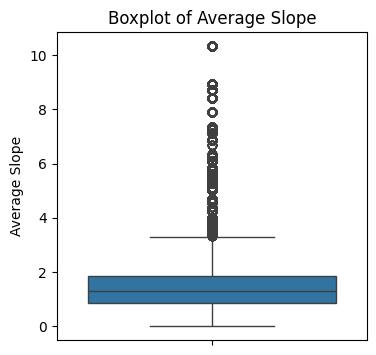

In [48]:
plt.figure(figsize=(4, 4))
sns.boxplot(y='avg_slope', data=races_df)
plt.title('Boxplot of Average Slope')
plt.ylabel('Average Slope')
plt.show()

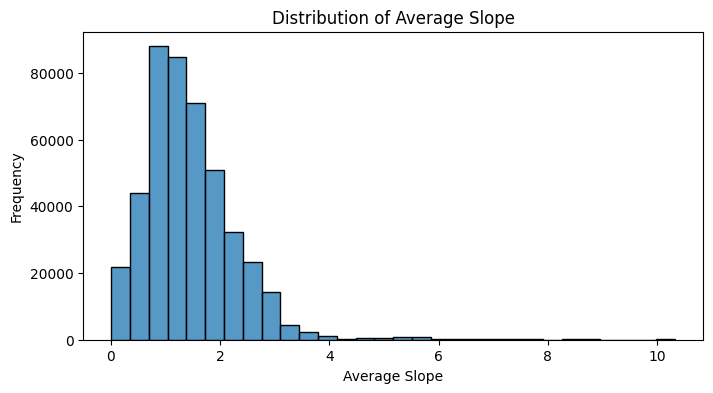

In [49]:
# Plot the distribution of the average slope
plt.figure(figsize=(8, 4))
sns.histplot(races_df['avg_slope'], bins=30)
plt.title('Distribution of Average Slope')
plt.xlabel('Average Slope')
plt.ylabel('Frequency')
plt.show()

#### ```strength_idx``` column

The <b>Cyclist's  Strength</b> Indicator would essentially represent each cyclist's typical competitiveness level by averaging the startlist_quality scores across all stages they participated in. This feature can give insight into a cyclist's experience and the overall competitiveness of the races they've been involved in.

In [50]:
# compute the average startlist quality for each cyclist
cyclist_strength = races_df.groupby('cyclist')['startlist_quality'].mean().reset_index()
cyclist_strength.rename(columns={'startlist_quality': 'strength_idx'}, inplace=True)

cyclists_df = cyclists_df.merge(cyclist_strength, left_on='_url', right_on='cyclist', how='left')


In [51]:
print(f"Null values in strength_idx column: {int(cyclists_df['strength_idx'].isnull().sum())}")

Null values in strength_idx column: 39


In [52]:
cyclists_df['strength_idx'].describe()

count    6095.000000
mean      967.626303
std       301.861307
min       115.000000
25%       798.017857
50%       951.521008
75%      1127.177404
max      1994.000000
Name: strength_idx, dtype: float64

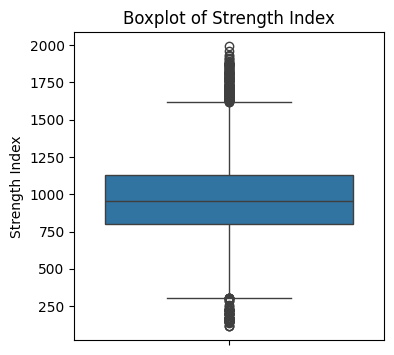

In [53]:
plt.figure(figsize=(4, 4))
sns.boxplot(y='strength_idx', data=cyclists_df)
plt.title('Boxplot of Strength Index')
plt.ylabel('Strength Index')
plt.show()

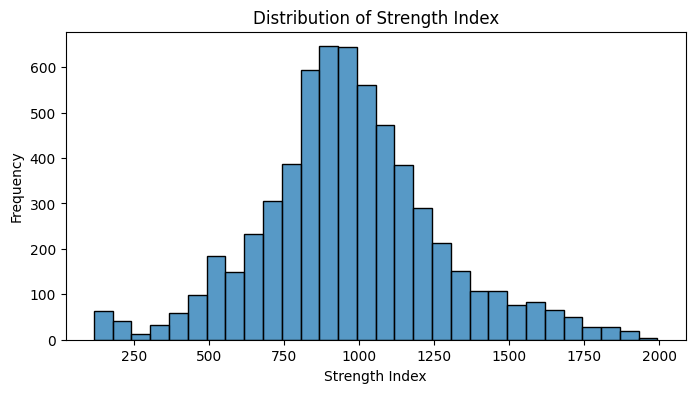

In [54]:
# Plot the distribution of the strength index
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['strength_idx'], bins=30)
plt.title('Distribution of Strength Index')
plt.xlabel('Strength Index')
plt.ylabel('Frequency')
plt.show()

#### ```best_position``` column

Given that many of them never won a stage, this column represents the best position achieved by a rider in a stage.

In [55]:
best_finish_position = races_df.groupby('cyclist')['position'].min().reset_index()

# Step 2: Rename the column for clarity
best_finish_position.rename(columns={'position': 'best_position'}, inplace=True)

# Step 3: Merge the result back to the original DataFrame
cyclists_df = cyclists_df.merge(best_finish_position, left_on='_url', right_on='cyclist', how='left')

cyclists_df.drop(columns=['cyclist_x'], inplace=True)

In [56]:
print(f"Null values in best_position column: {int(cyclists_df['best_position'].isnull().sum())}")

Null values in best_position column: 39


In [57]:
cyclists_df['best_position'].describe()

count    6095.000000
mean       22.628876
std        33.280295
min         0.000000
25%         1.000000
50%         7.000000
75%        30.000000
max       205.000000
Name: best_position, dtype: float64

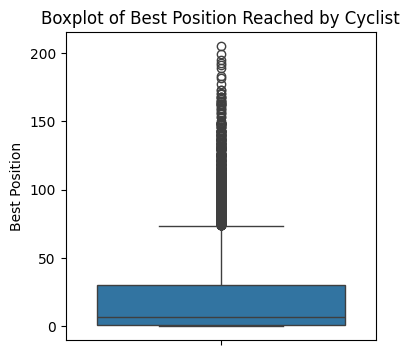

In [58]:
plt.figure(figsize=(4, 4))
sns.boxplot(y='best_position', data=cyclists_df)
plt.title('Boxplot of Best Position Reached by Cyclist')
plt.ylabel('Best Position')
plt.show()

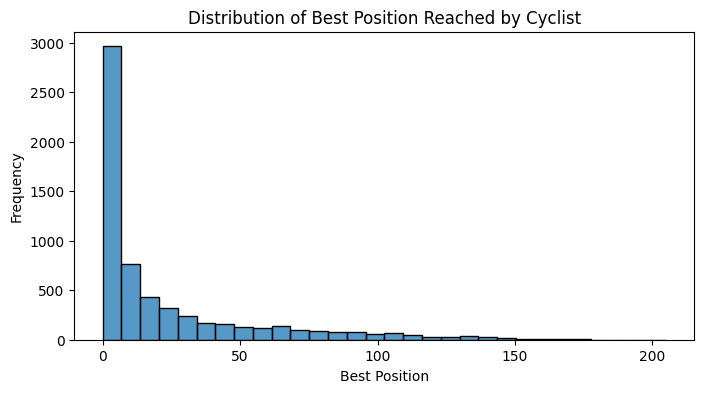

In [59]:
# Plot the distribution of the strength index
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['best_position'], bins=30)
plt.title('Distribution of Best Position Reached by Cyclist')
plt.xlabel('Best Position')
plt.ylabel('Frequency')
plt.show()

Checking the number of races in which cyclists who have never finished above 150th position have participated, with the assumption that these are cyclists with participation limited to a few stages or a single stage.

In [60]:
# Filter cyclists who have never finished above 150th position
cyclists_never_above_150 = cyclists_df[cyclists_df['best_position'] > 150]['_url']

# Filter races_df to include only these cyclists
races_never_above_150 = races_df[races_df['cyclist'].isin(cyclists_never_above_150)]

# Count the number of stages each of these cyclists has participated in
# NOTE: at this point no cyclist has a duplicated entry in the same stage
races_count_never_above_150 = races_never_above_150['cyclist'].value_counts()

# Merge the counts with the best positions
races_count_with_best_position = races_count_never_above_150.to_frame().merge(
    cyclists_df, left_index=True, right_on='_url',
).rename(columns={'_url': 'cyclist name', 'count': 'Number of Stages', 'best_position': 'Best Position'})

# Display the result
print(races_count_with_best_position[['cyclist name', 'Number of Stages', 'Best Position']])

                            cyclist name  Number of Stages  Best Position
1710                    manabu-ishibashi                 7          163.0
1194                 wanderley-magalhaes                 4          168.0
1256                  claudio-jose-casas                 4          168.0
4879                        romain-gioux                 3          153.0
4471                  kevin-de-mesmaeker                 2          158.0
602                        karol-rychlik                 2          173.0
2727                       denis-flahaut                 2          168.0
5158                       brian-kamstra                 2          157.0
4304                       alan-banaszek                 2          164.0
1919                    sergio-jaramillo                 2          191.0
133                          giulio-tomi                 1          156.0
5346                       marco-toffali                 1          163.0
2200                  juan-carlos-garc

As expected, these cyclists will take part in very few or only one stage.

#### ```best_position_std``` column

Given that many of them never won a stage, this column represents the best position achieved by a rider in a stage.

In [61]:
best_finish_position = races_df.groupby('cyclist')['position'].std().reset_index()

# Step 2: Rename the column for clarity
best_finish_position.rename(columns={'position': 'best_position_std'}, inplace=True)

# Step 3: Merge the result back to the original DataFrame
cyclists_df = cyclists_df.merge(best_finish_position, left_on='_url', right_on='cyclist', how='left')

In [62]:
print(f"Null values in best_position_std column: {int(cyclists_df['best_position_std'].isnull().sum())}")

Null values in best_position_std column: 742


In [63]:
cyclists_df['best_position_std'].describe()

count    5392.000000
mean       37.294436
std        13.886510
min         0.000000
25%        29.888105
50%        38.976872
75%        45.809134
max       108.187338
Name: best_position_std, dtype: float64

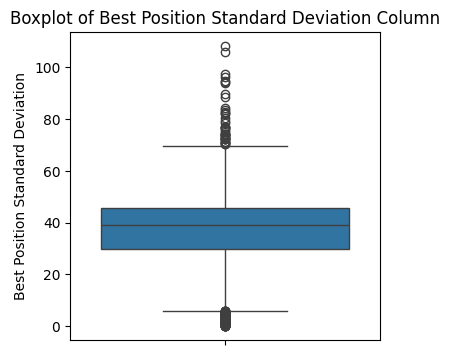

In [64]:
plt.figure(figsize=(4, 4))
sns.boxplot(y='best_position_std', data=cyclists_df)
plt.title('Boxplot of Best Position Standard Deviation Column')
plt.ylabel('Best Position Standard Deviation')
plt.show()

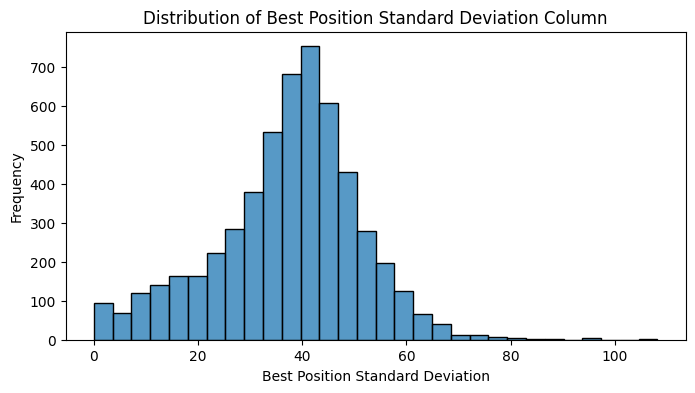

In [65]:
# Plot the distribution of the strength index
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['best_position_std'], bins=30)
plt.title('Distribution of Best Position Standard Deviation Column')
plt.xlabel('Best Position Standard Deviation')
plt.ylabel('Frequency')
plt.show()

TODO: comment what this results means, why high std? this probably means inconsistency trought time or similar things

#### ```cyclist_experience``` column

Count how many stages the cyclist partecipate as an overall experience

In [66]:
# Group by cyclist and count the number of stages each cyclist participated in 
# Note: aassuming no duplicates in same stage
stages_participated = races_df.groupby('cyclist').size().reset_index(name='cyclist_experience')

# Rename 'cyclist' in stages_participated to avoid conflicts
stages_participated = stages_participated.rename(columns={'cyclist': 'cyclist_id'})

# Merge the stages_participated with cyclists_df to add the 'cyclist_experience' column
# Specify suffixes to avoid duplicate columns
cyclists_df = cyclists_df.merge(stages_participated, left_on='_url', right_on='cyclist_id', how='left')

# Drop the redundant 'cyclist_id' column from the merged DataFrame
cyclists_df = cyclists_df.drop(columns=['cyclist_id'])

# Replace NaN values in cyclist_experience with 0 (for cyclists with no participation records)
cyclists_df['cyclist_experience'] = cyclists_df['cyclist_experience'].fillna(0).astype(int)

# Check the output
print(cyclists_df[["_url", "cyclist_experience"]].head(3))

# Verify correctness of the computation (sum of cyclist_experience should match number of rows in races_df)
print("Total cyclist_experience:", cyclists_df['cyclist_experience'].sum())

cyclists_df.drop(columns=['cyclist_y'], inplace=True)
cyclists_df.drop(columns=['cyclist'], inplace=True)


          _url  cyclist_experience
0  bruno-surra                   1
1   gerard-rue                 222
2     jan-maas                  49
Total cyclist_experience: 589865


The sum is correct as we have as many entries as the rows in the dataset

In [67]:
print(f"Null values in cyclist_experience column: {int(cyclists_df['cyclist_experience'].isnull().sum())}")

Null values in cyclist_experience column: 0


In [68]:
cyclists_df['cyclist_experience'].describe()

count    6134.000000
mean       96.163189
std       140.566842
min         0.000000
25%         5.000000
50%        30.000000
75%       132.000000
max       959.000000
Name: cyclist_experience, dtype: float64

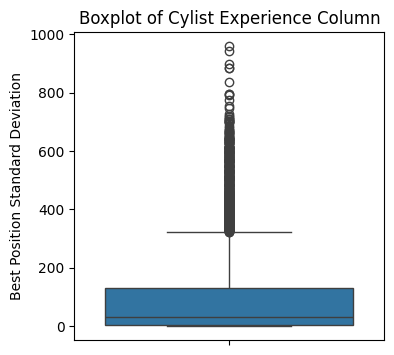

In [69]:
plt.figure(figsize=(4, 4))
sns.boxplot(y='cyclist_experience', data=cyclists_df)
plt.title('Boxplot of Cylist Experience Column')
plt.ylabel('Best Position Standard Deviation')
plt.show()

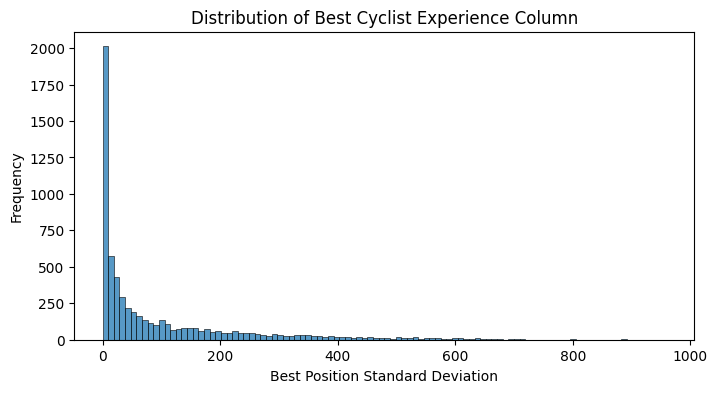

In [70]:
# Plot the distribution of the strength index
plt.figure(figsize=(8, 4))
sns.histplot(cyclists_df['cyclist_experience'], bins=100)
plt.title('Distribution of Best Cyclist Experience Column')
plt.xlabel('Best Position Standard Deviation')
plt.ylabel('Frequency')
plt.show()

In [71]:
cyclists_df.value_counts('cyclist_experience')

cyclist_experience
1      703
2      294
3      222
4      176
6      131
      ... 
518      1
519      1
520      1
522      1
959      1
Name: count, Length: 586, dtype: int64

#### ```km_per_year``` column

This column also represents the cyclist's overall experience. It highlights the total distance raced by the cyclist over the course of their career, calculated by aggregating the distances covered in all stages in which they have participated. The overall career span is defined as the interval between the initial and final stages of the cyclist's participation in these races.

In [72]:
# First compute overall Km raced by the cyclist

# Group by cyclist and sum number km raced
# Note: aassuming no duplicates in same stage
km_raced = races_df.groupby('cyclist')["length"].sum().reset_index(name='overall_km')
km_raced["overall_km"] = km_raced["overall_km"] / 1000

# Merge the km_raced with cyclists_df to add the 'km_per_year' column
cyclists_df = cyclists_df.merge(km_raced, left_on='_url', right_on='cyclist', how='left')

# Replace NaN values in km_per_year with 0 (for cyclists with no participation records)
cyclists_df['overall_km'] = cyclists_df['overall_km'].fillna(0).astype(int)

# Check the output
print(cyclists_df[["_url", "overall_km"]].head(3))

cyclists_df.drop(columns=['cyclist'], inplace=True)


          _url  overall_km
0  bruno-surra          20
1   gerard-rue       40897
2     jan-maas        8206


In [73]:
# Verify correctness of the computation (sum of km_per_year should match number of rows in races_df)
print(f"Total km_per_year: {cyclists_df['overall_km'].sum()} computed on races_df")
print(f"Total km_per_year: {km_raced['overall_km'].sum()} computed on km_raced on cyclists_df")

Total km_per_year: 98373045 computed on races_df
Total km_per_year: 98375431.76 computed on km_raced on cyclists_df


In [74]:
print(f"Null values in overall_km column: {int(cyclists_df['overall_km'].isnull().sum())}")

Null values in overall_km column: 0


In [75]:
# Count total yeras of career for each cyclist
career_span = races_df.groupby('cyclist')['start_date'].agg(['min', 'max'])
career_span['career_years'] = (pd.to_datetime(career_span['max']) - pd.to_datetime(career_span['min'])).dt.days + 1/ 365

# Merge the career_span with cyclists_df to add the 'career_years' column
cyclists_df = cyclists_df.merge(career_span[['career_years']], left_on='_url', right_index=True, how='left')

#print(cyclists_df.columns)

# Replace NaN values in career_years with 0 (for cyclists with no participation records)
cyclists_df['career_years'] = cyclists_df['career_years'].fillna(0).astype(float)

# Check the output
print(cyclists_df[["_url", "career_years"]].head(3))



          _url  career_years
0  bruno-surra       0.00274
1   gerard-rue    3492.00274
2     jan-maas     518.00274


In [76]:
cyclists_df['career_years'].describe()

count    6134.000000
mean     1625.673573
std      1630.500214
min         0.000000
25%       117.002740
50%      1108.502740
75%      2681.502740
max      9519.002740
Name: career_years, dtype: float64

In [77]:
cyclists_df['km_per_year'] = cyclists_df['overall_km'] / np.where(cyclists_df['career_years'] != 0, cyclists_df['career_years'], 1)
cyclists_df['km_per_year'] = cyclists_df['km_per_year'].round(2)

In [78]:
cyclists_df['km_per_year'].describe()

count      6134.000000
mean       9214.355514
std       26699.943462
min           0.000000
25%           4.540000
50%          10.640000
75%          21.005000
max      111325.000000
Name: km_per_year, dtype: float64

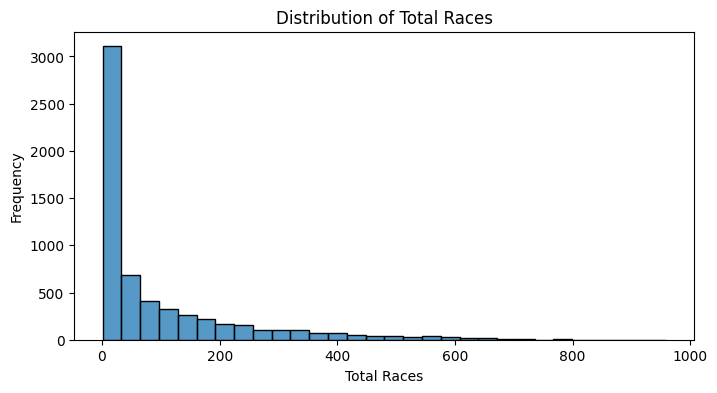

In [79]:
plt.figure(figsize=(8, 4))
sns.histplot(total_races, bins=30)
plt.title('Distribution of Total Races')
plt.xlabel('Total Races')
plt.ylabel('Frequency')
plt.show()

### CORRELATION ANALYSIS


Cyclists correlation analysis


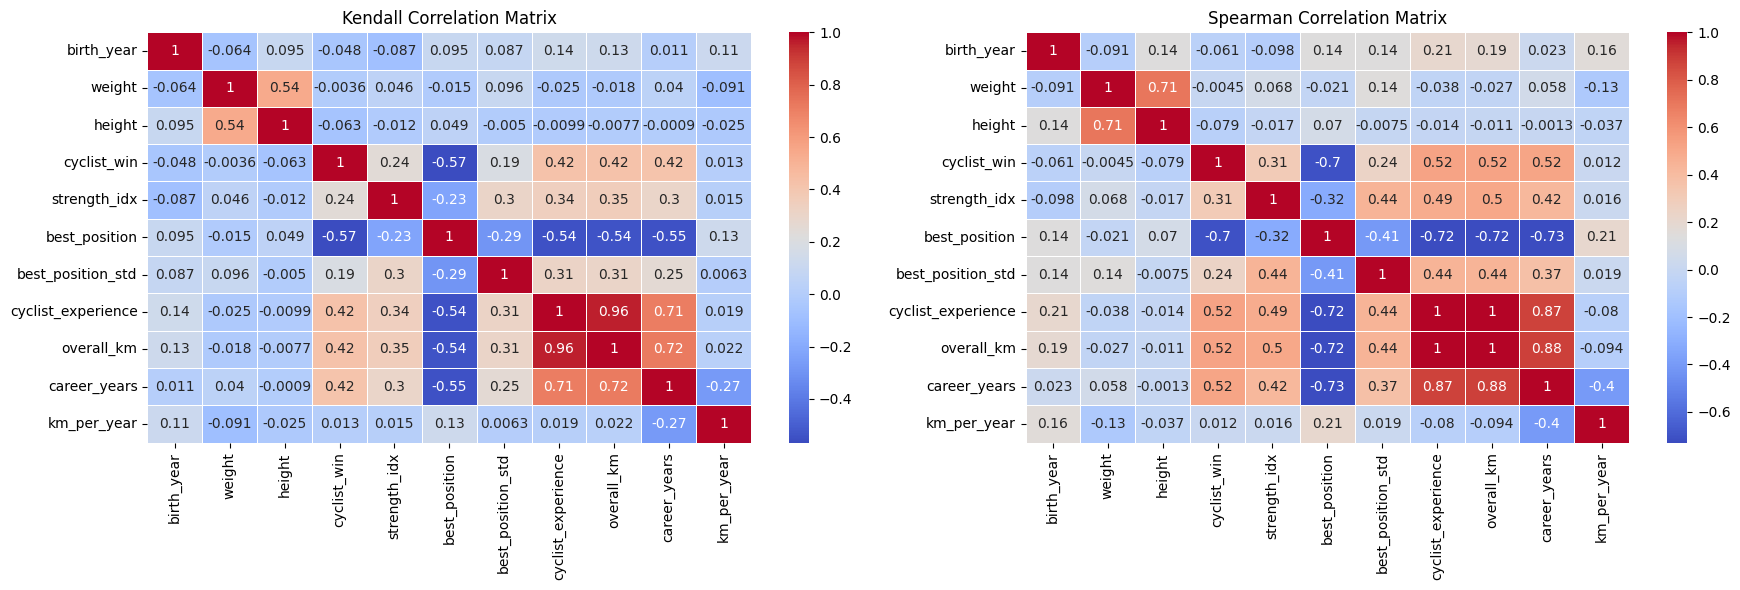

In [80]:
from utils import center_and_scale, correlations, plot_correlations

normalized_cyclist, normalization_scalers_cyclist = center_and_scale(cyclists_df)
cyclists_corr = correlations(normalized_cyclist)

plot_correlations(cyclists_corr)

Races correlation analysis


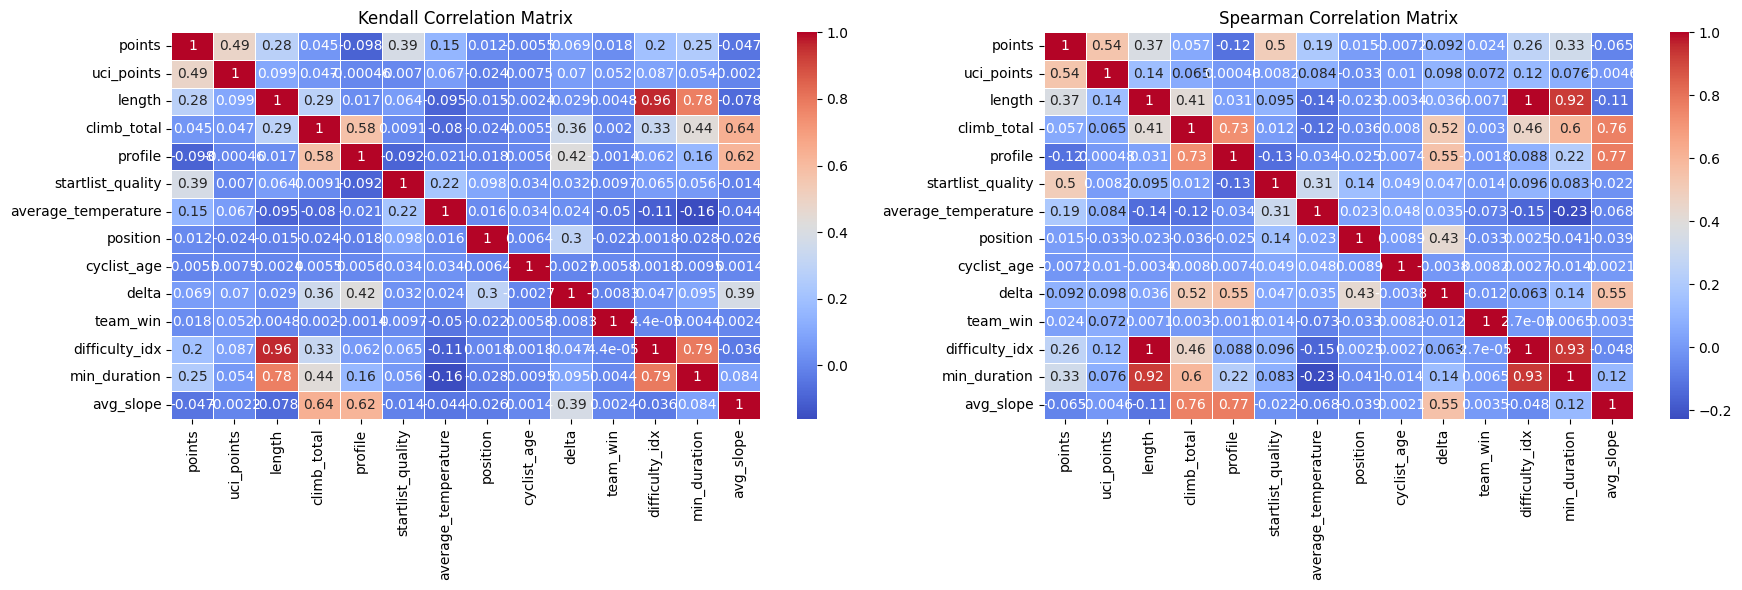

In [81]:
from utils import center_and_scale, correlations, plot_correlations

normalized_cyclist, normalization_scalers_cyclist = center_and_scale(races_df)
cyclists_corr = correlations(normalized_cyclist)

plot_correlations(cyclists_corr)